In [1]:
import tensorflow as tf
import numpy as np
import pandas as pd
import os, sys
import time
import datetime
import data_helpers
from text_cnn import TextCNN
from tensorflow.contrib import learn
import argparse

from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, classification_report, confusion_matrix

import matplotlib.pyplot as plt

sys.path.append("/home/put_data/moth/code/")
from katieyth import KT_func as kt

/usr/local/lib/python3.5/dist-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [2]:
parser = argparse.ArgumentParser() # 1: description 2: abbreviation(used in code)
parser.add_argument('--test_mode', dest='test_mode', default= True)
parser.add_argument('--gpu', dest='gpu', default='6')
parser.add_argument('--mode', type=str, default="train", help='Select "train", "test", or "predict" mode. \
    Note that for prediction mode you have to specify an image to run the model on.')
parser.add_argument('--model', dest='model', default='TextCNN') 
# basic tuning
parser.add_argument('--batch_size', dest = 'bz', type=int, default=64, help='Number of images in each batch')
parser.add_argument('--earlystop_patience', dest='earlystop_patience', default=25, type=float)
parser.add_argument('--num_class', dest='num_class', default= 6, type=int)
parser.add_argument('--out-dir', dest='out_dir', default='../Product_name_classifier')
parser.add_argument('--epoch', dest='epoch', type=int, default=300)
parser.add_argument('--lr', '--learning-rate', dest='lr', type=float, default=1e-6)
parser.add_argument('--lr_patience', dest='lr_patience', default= 2, type=int)
parser.add_argument('--min_lr', dest='min_lr', default=1e-10, type=float)
parser.add_argument('--min_delta', dest='min_delta', default=0, type=float)
parser.add_argument('--lr_reduce_factor', dest='lr_reduce_factor', default= 0.5, type=float)

# depends on task
parser.add_argument('--embedding_dim',dest='embedding_dim', default= 128, type=int)
parser.add_argument('--filter_sizes',dest='filter_sizes', default= "3,4,5", type=str)
parser.add_argument('--num_filters',dest='num_filters', default= 128, type=int)
parser.add_argument('--dropout_keep_prob',dest='dropout_keep_prob', default= 0.5, type=float)
parser.add_argument('--l2_reg_lambda',dest='l2_reg_lambda', default= 0.0, type=float)
parser.add_argument('--allow_soft_placement',dest='allow_soft_placement', default= True)
parser.add_argument('--log_device_placement',dest='log_device_placement', default= False)
parser.add_argument('--test2train_percentage',dest='test2train_per', default= 0.1)
parser.add_argument('--val_percentage',dest='val_per', default= 1/9)


args = parser.parse_args([]) # () if .py
os.environ["CUDA_VISIBLE_DEVICES"] = args.gpu

In [3]:
outdir = os.path.join(args.out_dir, args.model)
if args.test_mode:
    outdir = os.path.join(args.out_dir, args.model,'test')
if args.mode =='train':
    running_date = time.strftime("%y%m%d")
    running_time = time.strftime("%H%M%S")
    log_path    = os.path.join(outdir, running_date, running_time, 'train.log')
    model_dir   = os.path.join(outdir, running_date, running_time, 'model')
    img_dir     = os.path.join(outdir, running_date, running_time, 'image')
    tsboard_dir = os.path.join(outdir, running_date, running_time, 'tsboard')
    
    dir_list = [model_dir, img_dir, tsboard_dir]
            
elif args.mode =='predict':
    tg_date = args.tg_model_date
    tg_time = args.tg_model_time
    running_date = time.strftime("%y%m%d")
    running_time = time.strftime("%H%M%S")
    log_path    = os.path.join(outdir, tg_date, tg_time, 'predict',running_date,running_time, 'predict.log')
    predict_dir = os.path.join(outdir, tg_date, tg_time, 'predict',running_date,running_time)
    
    dir_list = [predict_dir]


for tg in dir_list:
    if not os.path.exists(tg):
        os.makedirs(tg)
log = kt.LOGGER(log_path)
log.log('Find ME: %s' %(log_path))
log.log('PID: %s' %(os.getpid()))
log.log('\n %s' % (args))


[2018-07-18 18:37:46] Find ME: ../Product_name_classifier/TextCNN/test/180718/183746/train.log
[2018-07-18 18:37:46] PID: 8006
[2018-07-18 18:37:46] 
 Namespace(allow_soft_placement=True, bz=64, dropout_keep_prob=0.5, earlystop_patience=25, embedding_dim=128, epoch=300, filter_sizes='3,4,5', gpu='6', l2_reg_lambda=0.0, log_device_placement=False, lr=1e-06, lr_patience=2, lr_reduce_factor=0.5, min_delta=0, min_lr=1e-10, mode='train', model='TextCNN', num_class=6, num_filters=128, out_dir='../Product_name_classifier', test2train_per=0.1, test_mode=True, val_per=0.1111111111111111)


In [4]:
from itertools import cycle
from random import shuffle
class RandomRoundRobin(object):
    def __init__(self, data, bz, random_after_epoch=True):
        self.data = data
        self.batch_size = bz
        self.batch_data = self._get_item()
        self.random_after_epoch = random_after_epoch

    def _get_item(self):
        for i, item in enumerate(cycle(self.data)):
            yield (i, item)

    def next_batch(self):
        data = []
        for i in range(self.batch_size):
            count, item = self.batch_data.__next__()
            data.append(item)
            if count == len(self.data)-1 and self.random_after_epoch:
                shuffle(self.data)
                self.batch_data = self._get_item()
        return data


In [5]:
class DataGenerator(object):
    def __init__(self, random_after_epoch=True):
        self.random_after_epoch = random_after_epoch

    def gen_train_data(self, pair_data, bz=1):
        #pair_data = list(zip(x_in, y_out))
        rrr = RandomRoundRobin(pair_data, bz, self.random_after_epoch)
        while True:
            batch = rrr.next_batch()
            x = [i[0] for i in batch]
            y = [i[1] for i in batch]
            yield x, y

    def get_test_data(self, pair_data, bz=1):
        #pair_image = list(zip(x_in, y_out))
        rrr = RandomRoundRobin(pair_data, bz, self.random_after_epoch)
        while True:
            batch = rrr.next_batch()
            x = [i[0] for i in batch]
            y = [i[1] for i in batch]
            yield x, y
            

In [6]:
import jieba
import jieba.analyse
def cut_text(text_list):
    jieba.enable_parallel(20)

    jieba.set_dictionary("../Head-first-Chinese-text-segmentation/data/dict.txt.big")
    jieba.analyse.set_stop_words("../Head-first-Chinese-text-segmentation/data/stop_words.txt")

    #  jieba.analyse.set_idf_path(file_name) 
    #  jieba.load_userdict(file_name)

    #  jieba.add_word('台中') 或者 jieba.suggest_freq('台中', True)
    #  jieba.del_word('今天天气') 或者 jieba.suggest_freq(('今天', '天气'), True) 

    word_list = []
    n = 0
    for content in text_list:
        #print ("Input：", content)
        n+=1
        print(n, end ='\r')

        tags = jieba.analyse.extract_tags(content, 100)
        #tags = jieba.cut(content, HMM=True)
        tags = " ".join(tags)
        word_list.append(tags)
        #print(tags)
        #print('\t'," ".join(tags) )


        #seg_list = jieba.cut("我来到北京清华大学", cut_all=False)
        # but beed to remove ', 。 etc'

    jieba.disable_parallel()
    return word_list

In [7]:
def train_step(x_batch, y_batch):
    """
    A single training step
    """
    feed_dict = {
      cnn.input_x: x_batch,
      cnn.input_y: y_batch,
      cnn.dropout_keep_prob: args.dropout_keep_prob
    }
    _, step, summaries, loss, accuracy = sess.run(
        [train_op, global_step, train_summary_op, cnn.loss, cnn.accuracy],
        feed_dict)
    time_str = datetime.datetime.now().isoformat()
    #print("{}: step {}, loss {:g}, acc {:g}".format(time_str, step, loss, accuracy))
    train_summary_writer.add_summary(summaries, step)
    return loss, accuracy


In [8]:
 def dev_step(x_batch, y_batch, writer=None):
    """
    Evaluates model on a dev set
    """
    feed_dict = {
      cnn.input_x: x_batch,
      cnn.input_y: y_batch,
      cnn.dropout_keep_prob: 1.0
    }
    step, summaries, loss, accuracy, pred = sess.run(
        [global_step, dev_summary_op, cnn.loss, cnn.accuracy, cnn.predictions],
        feed_dict)
    time_str = datetime.datetime.now().isoformat()
    #print("{}: step {}, loss {:g}, acc {:g}".format(time_str, step, loss, accuracy))
    if writer:
        writer.add_summary(summaries, step)
    return loss, accuracy, pred


In [9]:
def plt_learning_curve(train_loss_noted, valid_loss_noted):
    plt.plot(np.arange(len(train_loss_noted)), train_loss_noted, 'b', label = 'train')
    plt.plot(np.arange(len(valid_loss_noted)), valid_loss_noted, 'r', label = 'valid')
    if args.num_class ==1:
        plt.ylim(args.plt_loss_min, args.plt_loss_max)
    plt.title('Loss')
    plt.legend(loc='best')
    plt.savefig(img_dir+'/'+running_date+'_'+running_time+'_fold_'+ str(idx_fold)+ '.png') # Use fig. here
    #plt.savefig(img_dir+'/'+log_time_str+'_fold_'+ str(idx_fold)+'.png')
    #plt.show()
    plt.close()

In [10]:
def get_lr_step_patience(save=True, tp = 'rdlr'):
    global l_rate, step_patience_counter, lr_patience_counter, current_best_val_loss
    if epoch_counter == 1:
        lr_patience_counter = lr_patience_counter
        l_rate = l_rate
        step_patience_counter = step_patience_counter
    elif current_best_val_loss is None or current_best_val_loss - params['valid_loss'][-1] > args.min_delta:
        #print('improve')
        lr_patience_counter = 0
        step_patience_counter = 0
        current_best_val_loss = params['valid_loss'][-1]
        checkpoint_path = model_dir +'/'+running_date+'_'+running_time+'_fold_'+ str(idx_fold)
        saver.save(sess,checkpoint_path)
        
    else:
        #print('X')
        lr_patience_counter += 1
        step_patience_counter += 1

            
    if lr_patience_counter == args.lr_patience:
        l_rate *= args.lr_reduce_factor
        lr_patience_counter = 0
        log.log("------------[REDUCE learning rate] to %s" % (l_rate))

    if l_rate <= args.min_lr:
        l_rate = args.min_lr

    
    return  step_patience_counter, l_rate, lr_patience_counter
        

In [11]:
def get_epoch_report():
    global epoch_counter, step_patience_counter, train_epoch_loss,valid_epoch_loss,l_rate, train_epoch_acc, valid_epoch_acc
    string_print=("EP(%s/%s) PT(%s/%s)---TR/VL-LOSS[%.4f/%.4f] ACC[%.4f/%.4f]|%s secs|l-rate:%s"
            %(epoch_counter,args.epoch,step_patience_counter, args.earlystop_patience,train_epoch_loss,valid_epoch_loss,train_epoch_acc, valid_epoch_acc,round(time.time()-st,2),l_rate))

    log.log(string_print)

Building prefix dict from the default dictionary ...
Loading model from cache /tmp/jieba.cache
Loading model cost 0.842 seconds.
Prefix dict has been built succesfully.
Building prefix dict from /home/katieyth/eReceipt/Head-first-Chinese-text-segmentation/data/dict.txt.big ...
Loading model from cache /tmp/jieba.u09c6586fc910ac41ac55d33d8714705d.cache


Loading model cost 1.471 seconds.
Prefix dict has been built succesfully.


Fold 0
Vocabulary Size: 7948
Train/Valid/Test split: 17752/2219/2219
(7948, 128)
(?, 12, 128)
h: (?, 10, 1, 128)
pooled: (?, 1, 1, 128)
h: (?, 9, 1, 128)
pooled: (?, 1, 1, 128)
h: (?, 8, 1, 128)
pooled: (?, 1, 1, 128)
self.h_pool: (?, 1, 1, 384)
INFO:tensorflow:Summary name embedding/W:0/grad/hist is illegal; using embedding/W_0/grad/hist instead.
INFO:tensorflow:Summary name embedding/W:0/grad/sparsity is illegal; using embedding/W_0/grad/sparsity instead.
INFO:tensorflow:Summary name conv-maxpool-3/W:0/grad/hist is illegal; using conv-maxpool-3/W_0/grad/hist instead.
INFO:tensorflow:Summary name conv-maxpool-3/W:0/grad/sparsity is illegal; using conv-maxpool-3/W_0/grad/sparsity instead.
INFO:tensorflow:Summary name conv-maxpool-3/b:0/grad/hist is illegal; using conv-maxpool-3/b_0/grad/hist instead.
INFO:tensorflow:Summary name conv-maxpool-3/b:0/grad/sparsity is illegal; using conv-maxpool-3/b_0/grad/sparsity instead.
INFO:tensorflow:Summary name conv-maxpool-4/W:0/grad/hist is illeg

[2018-07-18 18:38:14] EP(44/300) PT(3/25)---TR/VL-LOSS[0.8727/0.8006] ACC[0.7266/0.7422]|0.23 secs|l-rate:1e-10
[2018-07-18 18:38:14] ------------[REDUCE learning rate] to 5e-11
[2018-07-18 18:38:15] EP(45/300) PT(4/25)---TR/VL-LOSS[0.8420/0.6134] ACC[0.7188/0.7578]|0.15 secs|l-rate:1e-10
[2018-07-18 18:38:15] EP(46/300) PT(0/25)---TR/VL-LOSS[0.8101/0.8504] ACC[0.6953/0.7266]|0.22 secs|l-rate:1e-10
[2018-07-18 18:38:15] EP(47/300) PT(1/25)---TR/VL-LOSS[1.0525/1.0284] ACC[0.6641/0.6719]|0.24 secs|l-rate:1e-10
[2018-07-18 18:38:15] ------------[REDUCE learning rate] to 5e-11
[2018-07-18 18:38:15] EP(48/300) PT(2/25)---TR/VL-LOSS[1.1378/0.8078] ACC[0.6406/0.7812]|0.21 secs|l-rate:1e-10
[2018-07-18 18:38:16] EP(49/300) PT(3/25)---TR/VL-LOSS[0.7751/0.6475] ACC[0.7734/0.8203]|0.23 secs|l-rate:1e-10
[2018-07-18 18:38:16] ------------[REDUCE learning rate] to 5e-11
[2018-07-18 18:38:16] EP(50/300) PT(4/25)---TR/VL-LOSS[0.6419/0.7589] ACC[0.7812/0.7344]|0.26 secs|l-rate:1e-10
[2018-07-18 18:38:

[2018-07-18 18:38:29] EP(9/300) PT(6/25)---TR/VL-LOSS[0.7023/0.6405] ACC[0.8047/0.8125]|0.23 secs|l-rate:1.25e-07
[2018-07-18 18:38:29] EP(10/300) PT(7/25)---TR/VL-LOSS[0.6012/0.4870] ACC[0.8281/0.8594]|0.25 secs|l-rate:1.25e-07
[2018-07-18 18:38:29] ------------[REDUCE learning rate] to 6.25e-08
[2018-07-18 18:38:29] EP(11/300) PT(8/25)---TR/VL-LOSS[0.7368/0.4490] ACC[0.7500/0.8594]|0.17 secs|l-rate:6.25e-08
[2018-07-18 18:38:29] EP(12/300) PT(0/25)---TR/VL-LOSS[0.5306/0.4603] ACC[0.8203/0.8672]|0.22 secs|l-rate:6.25e-08
[2018-07-18 18:38:30] EP(13/300) PT(1/25)---TR/VL-LOSS[0.9881/0.5190] ACC[0.6797/0.8750]|0.19 secs|l-rate:6.25e-08
[2018-07-18 18:38:30] ------------[REDUCE learning rate] to 3.125e-08
[2018-07-18 18:38:30] EP(14/300) PT(2/25)---TR/VL-LOSS[0.6552/0.6049] ACC[0.7812/0.8047]|0.19 secs|l-rate:3.125e-08
[2018-07-18 18:38:30] EP(15/300) PT(3/25)---TR/VL-LOSS[0.5743/0.6397] ACC[0.8438/0.7422]|0.23 secs|l-rate:3.125e-08
[2018-07-18 18:38:30] ------------[REDUCE learning rate

/usr/local/lib/python3.5/dist-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/usr/local/lib/python3.5/dist-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


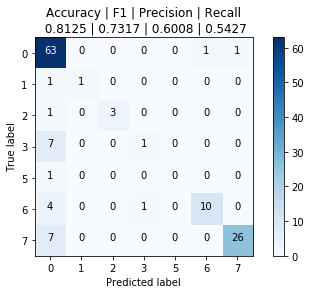

Building prefix dict from /home/katieyth/eReceipt/Head-first-Chinese-text-segmentation/data/dict.txt.big ...
Loading model from cache /tmp/jieba.u09c6586fc910ac41ac55d33d8714705d.cache


Loading model cost 1.536 seconds.
Prefix dict has been built succesfully.


Fold 1
Vocabulary Size: 7948
Train/Valid/Test split: 17752/2219/2219
(7948, 128)
(?, 12, 128)
h: (?, 10, 1, 128)
pooled: (?, 1, 1, 128)
h: (?, 9, 1, 128)
pooled: (?, 1, 1, 128)
h: (?, 8, 1, 128)
pooled: (?, 1, 1, 128)
self.h_pool: (?, 1, 1, 384)
INFO:tensorflow:Summary name embedding/W:0/grad/hist is illegal; using embedding/W_0/grad/hist instead.
INFO:tensorflow:Summary name embedding/W:0/grad/sparsity is illegal; using embedding/W_0/grad/sparsity instead.
INFO:tensorflow:Summary name conv-maxpool-3/W:0/grad/hist is illegal; using conv-maxpool-3/W_0/grad/hist instead.
INFO:tensorflow:Summary name conv-maxpool-3/W:0/grad/sparsity is illegal; using conv-maxpool-3/W_0/grad/sparsity instead.
INFO:tensorflow:Summary name conv-maxpool-3/b:0/grad/hist is illegal; using conv-maxpool-3/b_0/grad/hist instead.
INFO:tensorflow:Summary name conv-maxpool-3/b:0/grad/sparsity is illegal; using conv-maxpool-3/b_0/grad/sparsity instead.
INFO:tensorflow:Summary name conv-maxpool-4/W:0/grad/hist is illeg

[2018-07-18 18:38:59] EP(45/300) PT(7/25)---TR/VL-LOSS[0.8860/0.7954] ACC[0.7109/0.7578]|0.24 secs|l-rate:1.220703125e-10
[2018-07-18 18:38:59] ------------[REDUCE learning rate] to 6.103515625e-11
[2018-07-18 18:38:59] EP(46/300) PT(8/25)---TR/VL-LOSS[0.9436/0.9160] ACC[0.6719/0.7109]|0.25 secs|l-rate:1e-10
[2018-07-18 18:38:59] EP(47/300) PT(9/25)---TR/VL-LOSS[1.0036/0.6935] ACC[0.7031/0.7344]|0.18 secs|l-rate:1e-10
[2018-07-18 18:38:59] ------------[REDUCE learning rate] to 5e-11
[2018-07-18 18:38:59] EP(48/300) PT(10/25)---TR/VL-LOSS[1.0572/0.6552] ACC[0.6797/0.7734]|0.21 secs|l-rate:1e-10
[2018-07-18 18:39:00] EP(49/300) PT(0/25)---TR/VL-LOSS[0.7848/0.6425] ACC[0.7969/0.8203]|0.22 secs|l-rate:1e-10
[2018-07-18 18:39:00] EP(50/300) PT(0/25)---TR/VL-LOSS[0.7902/0.6515] ACC[0.7578/0.7734]|0.22 secs|l-rate:1e-10
[2018-07-18 18:39:00] EP(51/300) PT(1/25)---TR/VL-LOSS[0.9394/0.6971] ACC[0.6875/0.7812]|0.25 secs|l-rate:1e-10
[2018-07-18 18:39:00] ------------[REDUCE learning rate] to 5e-

[2018-07-18 18:39:13] EP(103/300) PT(13/25)---TR/VL-LOSS[0.6992/0.5413] ACC[0.8047/0.8359]|0.36 secs|l-rate:1e-10
[2018-07-18 18:39:13] ------------[REDUCE learning rate] to 5e-11
[2018-07-18 18:39:13] EP(104/300) PT(14/25)---TR/VL-LOSS[0.6625/0.5365] ACC[0.7891/0.8125]|0.24 secs|l-rate:1e-10
[2018-07-18 18:39:13] EP(105/300) PT(15/25)---TR/VL-LOSS[0.5782/0.6544] ACC[0.7812/0.8047]|0.19 secs|l-rate:1e-10
[2018-07-18 18:39:13] ------------[REDUCE learning rate] to 5e-11
[2018-07-18 18:39:14] EP(106/300) PT(16/25)---TR/VL-LOSS[0.7930/0.4877] ACC[0.7500/0.8359]|0.25 secs|l-rate:1e-10
[2018-07-18 18:39:14] EP(107/300) PT(17/25)---TR/VL-LOSS[0.9122/0.4939] ACC[0.7188/0.8594]|0.24 secs|l-rate:1e-10
[2018-07-18 18:39:14] ------------[REDUCE learning rate] to 5e-11
[2018-07-18 18:39:14] EP(108/300) PT(18/25)---TR/VL-LOSS[0.7114/0.7385] ACC[0.7969/0.7891]|0.2 secs|l-rate:1e-10
[2018-07-18 18:39:14] EP(109/300) PT(19/25)---TR/VL-LOSS[0.8023/0.4767] ACC[0.7500/0.8438]|0.24 secs|l-rate:1e-10
[2018

[2018-07-18 18:39:27] EP(48/300) PT(13/25)---TR/VL-LOSS[0.5067/0.5518] ACC[0.8516/0.8438]|0.25 secs|l-rate:1e-10
[2018-07-18 18:39:27] ------------[REDUCE learning rate] to 5e-11
[2018-07-18 18:39:27] EP(49/300) PT(14/25)---TR/VL-LOSS[0.3132/0.3345] ACC[0.9375/0.8750]|0.18 secs|l-rate:1e-10
[2018-07-18 18:39:28] EP(50/300) PT(0/25)---TR/VL-LOSS[0.4653/0.5995] ACC[0.8281/0.8203]|0.17 secs|l-rate:1e-10
[2018-07-18 18:39:28] EP(51/300) PT(1/25)---TR/VL-LOSS[0.5936/0.3521] ACC[0.8047/0.8750]|0.33 secs|l-rate:1e-10
[2018-07-18 18:39:28] ------------[REDUCE learning rate] to 5e-11
[2018-07-18 18:39:28] EP(52/300) PT(2/25)---TR/VL-LOSS[0.5490/0.4886] ACC[0.8047/0.8672]|0.14 secs|l-rate:1e-10
[2018-07-18 18:39:28] EP(53/300) PT(3/25)---TR/VL-LOSS[0.4985/0.4044] ACC[0.8750/0.8750]|0.19 secs|l-rate:1e-10
[2018-07-18 18:39:28] ------------[REDUCE learning rate] to 5e-11
[2018-07-18 18:39:29] EP(54/300) PT(4/25)---TR/VL-LOSS[0.6176/0.3437] ACC[0.8359/0.8906]|0.16 secs|l-rate:1e-10
[2018-07-18 18:3

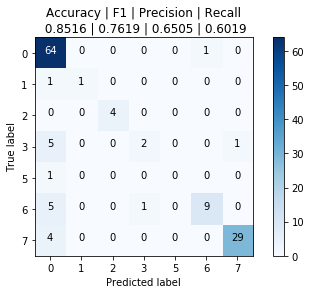

Building prefix dict from /home/katieyth/eReceipt/Head-first-Chinese-text-segmentation/data/dict.txt.big ...
Loading model from cache /tmp/jieba.u09c6586fc910ac41ac55d33d8714705d.cache


Loading model cost 1.504 seconds.
Prefix dict has been built succesfully.


Fold 2
Vocabulary Size: 7948
Train/Valid/Test split: 17752/2219/2219
(7948, 128)
(?, 12, 128)
h: (?, 10, 1, 128)
pooled: (?, 1, 1, 128)
h: (?, 9, 1, 128)
pooled: (?, 1, 1, 128)
h: (?, 8, 1, 128)
pooled: (?, 1, 1, 128)
self.h_pool: (?, 1, 1, 384)
INFO:tensorflow:Summary name embedding/W:0/grad/hist is illegal; using embedding/W_0/grad/hist instead.
INFO:tensorflow:Summary name embedding/W:0/grad/sparsity is illegal; using embedding/W_0/grad/sparsity instead.
INFO:tensorflow:Summary name conv-maxpool-3/W:0/grad/hist is illegal; using conv-maxpool-3/W_0/grad/hist instead.
INFO:tensorflow:Summary name conv-maxpool-3/W:0/grad/sparsity is illegal; using conv-maxpool-3/W_0/grad/sparsity instead.
INFO:tensorflow:Summary name conv-maxpool-3/b:0/grad/hist is illegal; using conv-maxpool-3/b_0/grad/hist instead.
INFO:tensorflow:Summary name conv-maxpool-3/b:0/grad/sparsity is illegal; using conv-maxpool-3/b_0/grad/sparsity instead.
INFO:tensorflow:Summary name conv-maxpool-4/W:0/grad/hist is illeg

[2018-07-18 18:39:54] EP(44/300) PT(13/25)---TR/VL-LOSS[1.0108/0.7909] ACC[0.6406/0.7422]|0.23 secs|l-rate:1e-10
[2018-07-18 18:39:54] ------------[REDUCE learning rate] to 5e-11
[2018-07-18 18:39:54] EP(45/300) PT(14/25)---TR/VL-LOSS[0.8739/0.9445] ACC[0.7422/0.7188]|0.23 secs|l-rate:1e-10
[2018-07-18 18:39:55] EP(46/300) PT(15/25)---TR/VL-LOSS[0.9459/0.6643] ACC[0.6484/0.7344]|0.21 secs|l-rate:1e-10
[2018-07-18 18:39:55] EP(47/300) PT(0/25)---TR/VL-LOSS[1.1453/0.8021] ACC[0.6953/0.7891]|0.25 secs|l-rate:1e-10
[2018-07-18 18:39:55] EP(48/300) PT(1/25)---TR/VL-LOSS[1.0462/0.7932] ACC[0.6875/0.8047]|0.19 secs|l-rate:1e-10
[2018-07-18 18:39:55] ------------[REDUCE learning rate] to 5e-11
[2018-07-18 18:39:55] EP(49/300) PT(2/25)---TR/VL-LOSS[0.9250/0.7816] ACC[0.7031/0.7500]|0.16 secs|l-rate:1e-10
[2018-07-18 18:39:56] EP(50/300) PT(3/25)---TR/VL-LOSS[0.7471/0.5916] ACC[0.7266/0.7969]|0.18 secs|l-rate:1e-10
[2018-07-18 18:39:56] EP(51/300) PT(0/25)---TR/VL-LOSS[1.0901/0.6766] ACC[0.6719/

[2018-07-18 18:40:08] EP(5/300) PT(2/25)---TR/VL-LOSS[0.6085/0.4846] ACC[0.8047/0.8438]|0.21 secs|l-rate:5e-07
[2018-07-18 18:40:08] EP(6/300) PT(0/25)---TR/VL-LOSS[0.7025/0.5734] ACC[0.8203/0.8047]|0.25 secs|l-rate:5e-07
[2018-07-18 18:40:08] EP(7/300) PT(1/25)---TR/VL-LOSS[0.5503/0.7608] ACC[0.8438/0.7422]|0.23 secs|l-rate:5e-07
[2018-07-18 18:40:08] ------------[REDUCE learning rate] to 2.5e-07
[2018-07-18 18:40:09] EP(8/300) PT(2/25)---TR/VL-LOSS[0.5617/0.4607] ACC[0.8125/0.8594]|0.25 secs|l-rate:2.5e-07
[2018-07-18 18:40:09] EP(9/300) PT(0/25)---TR/VL-LOSS[0.6199/0.4611] ACC[0.8047/0.8672]|0.27 secs|l-rate:2.5e-07
[2018-07-18 18:40:09] EP(10/300) PT(1/25)---TR/VL-LOSS[0.5945/0.4440] ACC[0.8203/0.8594]|0.26 secs|l-rate:2.5e-07
[2018-07-18 18:40:10] EP(11/300) PT(0/25)---TR/VL-LOSS[0.7617/0.4819] ACC[0.7500/0.8438]|0.25 secs|l-rate:2.5e-07
[2018-07-18 18:40:10] EP(12/300) PT(1/25)---TR/VL-LOSS[0.6805/0.6479] ACC[0.7969/0.7891]|0.18 secs|l-rate:2.5e-07
[2018-07-18 18:40:10] ---------

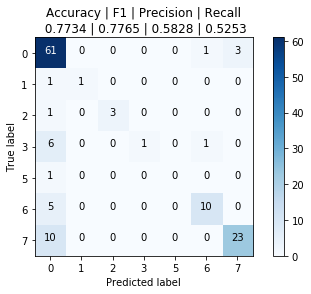

Building prefix dict from /home/katieyth/eReceipt/Head-first-Chinese-text-segmentation/data/dict.txt.big ...
Loading model from cache /tmp/jieba.u09c6586fc910ac41ac55d33d8714705d.cache


Loading model cost 1.371 seconds.
Prefix dict has been built succesfully.


Fold 3
Vocabulary Size: 7948
Train/Valid/Test split: 17752/2219/2219
(7948, 128)
(?, 12, 128)
h: (?, 10, 1, 128)
pooled: (?, 1, 1, 128)
h: (?, 9, 1, 128)
pooled: (?, 1, 1, 128)
h: (?, 8, 1, 128)
pooled: (?, 1, 1, 128)
self.h_pool: (?, 1, 1, 384)
INFO:tensorflow:Summary name embedding/W:0/grad/hist is illegal; using embedding/W_0/grad/hist instead.
INFO:tensorflow:Summary name embedding/W:0/grad/sparsity is illegal; using embedding/W_0/grad/sparsity instead.
INFO:tensorflow:Summary name conv-maxpool-3/W:0/grad/hist is illegal; using conv-maxpool-3/W_0/grad/hist instead.
INFO:tensorflow:Summary name conv-maxpool-3/W:0/grad/sparsity is illegal; using conv-maxpool-3/W_0/grad/sparsity instead.
INFO:tensorflow:Summary name conv-maxpool-3/b:0/grad/hist is illegal; using conv-maxpool-3/b_0/grad/hist instead.
INFO:tensorflow:Summary name conv-maxpool-3/b:0/grad/sparsity is illegal; using conv-maxpool-3/b_0/grad/sparsity instead.
INFO:tensorflow:Summary name conv-maxpool-4/W:0/grad/hist is illeg

[2018-07-18 18:40:38] EP(44/300) PT(3/25)---TR/VL-LOSS[0.9575/0.8262] ACC[0.7031/0.6641]|0.23 secs|l-rate:1e-10
[2018-07-18 18:40:38] ------------[REDUCE learning rate] to 5e-11
[2018-07-18 18:40:38] EP(45/300) PT(4/25)---TR/VL-LOSS[0.8093/0.8637] ACC[0.7344/0.7031]|0.21 secs|l-rate:1e-10
[2018-07-18 18:40:38] EP(46/300) PT(5/25)---TR/VL-LOSS[0.8403/0.6849] ACC[0.7188/0.7500]|0.24 secs|l-rate:1e-10
[2018-07-18 18:40:39] EP(47/300) PT(0/25)---TR/VL-LOSS[0.9719/0.7115] ACC[0.7188/0.7109]|0.25 secs|l-rate:1e-10
[2018-07-18 18:40:39] EP(48/300) PT(1/25)---TR/VL-LOSS[1.1302/0.8459] ACC[0.6406/0.7422]|0.14 secs|l-rate:1e-10
[2018-07-18 18:40:39] ------------[REDUCE learning rate] to 5e-11
[2018-07-18 18:40:39] EP(49/300) PT(2/25)---TR/VL-LOSS[0.7664/0.8285] ACC[0.7188/0.7500]|0.16 secs|l-rate:1e-10
[2018-07-18 18:40:39] EP(50/300) PT(3/25)---TR/VL-LOSS[0.6646/0.7832] ACC[0.7891/0.7656]|0.18 secs|l-rate:1e-10
[2018-07-18 18:40:39] ------------[REDUCE learning rate] to 5e-11
[2018-07-18 18:40:

[2018-07-18 18:40:52] EP(103/300) PT(0/25)---TR/VL-LOSS[0.6615/0.7611] ACC[0.7734/0.7500]|0.22 secs|l-rate:1e-10
[2018-07-18 18:40:52] EP(104/300) PT(1/25)---TR/VL-LOSS[0.7684/0.3700] ACC[0.7656/0.8984]|0.22 secs|l-rate:1e-10
[2018-07-18 18:40:52] EP(105/300) PT(0/25)---TR/VL-LOSS[0.7044/0.5298] ACC[0.7734/0.8359]|0.24 secs|l-rate:1e-10
[2018-07-18 18:40:53] EP(106/300) PT(1/25)---TR/VL-LOSS[0.6917/0.6264] ACC[0.8438/0.7891]|0.22 secs|l-rate:1e-10
[2018-07-18 18:40:53] ------------[REDUCE learning rate] to 5e-11
[2018-07-18 18:40:53] EP(107/300) PT(2/25)---TR/VL-LOSS[0.9164/0.5380] ACC[0.6953/0.8516]|0.24 secs|l-rate:1e-10
[2018-07-18 18:40:53] EP(108/300) PT(3/25)---TR/VL-LOSS[0.6404/0.5142] ACC[0.8125/0.8281]|0.23 secs|l-rate:1e-10
[2018-07-18 18:40:53] ------------[REDUCE learning rate] to 5e-11
[2018-07-18 18:40:53] EP(109/300) PT(4/25)---TR/VL-LOSS[0.7113/0.5354] ACC[0.7578/0.7969]|0.25 secs|l-rate:1e-10
[2018-07-18 18:40:54] EP(110/300) PT(5/25)---TR/VL-LOSS[0.5549/0.5035] ACC[0.

[2018-07-18 18:41:05] EP(31/300) PT(4/25)---TR/VL-LOSS[0.6825/0.3752] ACC[0.8516/0.8906]|0.24 secs|l-rate:1.220703125e-10
[2018-07-18 18:41:06] EP(32/300) PT(5/25)---TR/VL-LOSS[0.5843/0.5298] ACC[0.8359/0.8672]|0.27 secs|l-rate:1.220703125e-10
[2018-07-18 18:41:06] ------------[REDUCE learning rate] to 6.103515625e-11
[2018-07-18 18:41:06] EP(33/300) PT(6/25)---TR/VL-LOSS[0.4893/0.6029] ACC[0.8438/0.8438]|0.26 secs|l-rate:1e-10
[2018-07-18 18:41:06] EP(34/300) PT(7/25)---TR/VL-LOSS[0.4615/0.4776] ACC[0.8438/0.8594]|0.28 secs|l-rate:1e-10
[2018-07-18 18:41:06] ------------[REDUCE learning rate] to 5e-11
[2018-07-18 18:41:06] EP(35/300) PT(8/25)---TR/VL-LOSS[0.4243/0.5167] ACC[0.8906/0.8281]|0.25 secs|l-rate:1e-10
[2018-07-18 18:41:07] EP(36/300) PT(9/25)---TR/VL-LOSS[0.4599/0.4064] ACC[0.8750/0.8594]|0.25 secs|l-rate:1e-10
[2018-07-18 18:41:07] ------------[REDUCE learning rate] to 5e-11
[2018-07-18 18:41:07] EP(37/300) PT(10/25)---TR/VL-LOSS[0.4820/0.4903] ACC[0.8828/0.8438]|0.25 secs|

[2018-07-18 18:41:20] EP(90/300) PT(14/25)---TR/VL-LOSS[0.4969/0.4531] ACC[0.8281/0.8516]|0.23 secs|l-rate:1e-10
[2018-07-18 18:41:20] EP(91/300) PT(15/25)---TR/VL-LOSS[0.3536/0.3321] ACC[0.8594/0.9062]|0.24 secs|l-rate:1e-10
[2018-07-18 18:41:20] ------------[REDUCE learning rate] to 5e-11
[2018-07-18 18:41:21] EP(92/300) PT(16/25)---TR/VL-LOSS[0.5549/0.3195] ACC[0.8359/0.9297]|0.25 secs|l-rate:1e-10
[2018-07-18 18:41:21] EP(93/300) PT(17/25)---TR/VL-LOSS[0.3763/0.2280] ACC[0.8594/0.9531]|0.23 secs|l-rate:1e-10
[2018-07-18 18:41:21] EP(94/300) PT(0/25)---TR/VL-LOSS[0.2755/0.4516] ACC[0.9375/0.8594]|0.23 secs|l-rate:1e-10
[2018-07-18 18:41:21] EP(95/300) PT(1/25)---TR/VL-LOSS[0.3847/0.3021] ACC[0.8750/0.8828]|0.19 secs|l-rate:1e-10
[2018-07-18 18:41:21] ------------[REDUCE learning rate] to 5e-11
[2018-07-18 18:41:21] EP(96/300) PT(2/25)---TR/VL-LOSS[0.4360/0.4259] ACC[0.8906/0.8750]|0.14 secs|l-rate:1e-10
[2018-07-18 18:41:22] EP(97/300) PT(3/25)---TR/VL-LOSS[0.4098/0.4720] ACC[0.8906

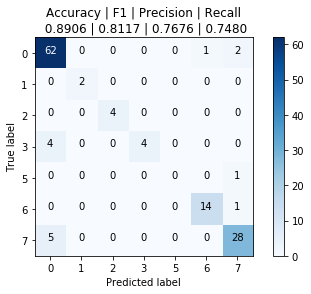

Building prefix dict from /home/katieyth/eReceipt/Head-first-Chinese-text-segmentation/data/dict.txt.big ...
Loading model from cache /tmp/jieba.u09c6586fc910ac41ac55d33d8714705d.cache


Loading model cost 1.539 seconds.
Prefix dict has been built succesfully.


Fold 4
Vocabulary Size: 7948
Train/Valid/Test split: 17752/2219/2219
(7948, 128)
(?, 12, 128)
h: (?, 10, 1, 128)
pooled: (?, 1, 1, 128)
h: (?, 9, 1, 128)
pooled: (?, 1, 1, 128)
h: (?, 8, 1, 128)
pooled: (?, 1, 1, 128)
self.h_pool: (?, 1, 1, 384)
INFO:tensorflow:Summary name embedding/W:0/grad/hist is illegal; using embedding/W_0/grad/hist instead.
INFO:tensorflow:Summary name embedding/W:0/grad/sparsity is illegal; using embedding/W_0/grad/sparsity instead.
INFO:tensorflow:Summary name conv-maxpool-3/W:0/grad/hist is illegal; using conv-maxpool-3/W_0/grad/hist instead.
INFO:tensorflow:Summary name conv-maxpool-3/W:0/grad/sparsity is illegal; using conv-maxpool-3/W_0/grad/sparsity instead.
INFO:tensorflow:Summary name conv-maxpool-3/b:0/grad/hist is illegal; using conv-maxpool-3/b_0/grad/hist instead.
INFO:tensorflow:Summary name conv-maxpool-3/b:0/grad/sparsity is illegal; using conv-maxpool-3/b_0/grad/sparsity instead.
INFO:tensorflow:Summary name conv-maxpool-4/W:0/grad/hist is illeg

[2018-07-18 18:41:47] EP(46/300) PT(2/25)---TR/VL-LOSS[0.8777/0.7219] ACC[0.6797/0.7734]|0.21 secs|l-rate:2.44140625e-10
[2018-07-18 18:41:48] EP(47/300) PT(3/25)---TR/VL-LOSS[0.9996/0.7539] ACC[0.7422/0.7500]|0.23 secs|l-rate:2.44140625e-10
[2018-07-18 18:41:48] ------------[REDUCE learning rate] to 1.220703125e-10
[2018-07-18 18:41:48] EP(48/300) PT(4/25)---TR/VL-LOSS[0.9314/0.8058] ACC[0.7109/0.7344]|0.22 secs|l-rate:1.220703125e-10
[2018-07-18 18:41:48] EP(49/300) PT(5/25)---TR/VL-LOSS[0.8427/0.7127] ACC[0.7500/0.7812]|0.24 secs|l-rate:1.220703125e-10
[2018-07-18 18:41:48] ------------[REDUCE learning rate] to 6.103515625e-11
[2018-07-18 18:41:48] EP(50/300) PT(6/25)---TR/VL-LOSS[0.7197/0.5197] ACC[0.7891/0.8672]|0.24 secs|l-rate:1e-10
[2018-07-18 18:41:49] EP(51/300) PT(0/25)---TR/VL-LOSS[0.9405/0.6064] ACC[0.6719/0.8047]|0.19 secs|l-rate:1e-10
[2018-07-18 18:41:49] EP(52/300) PT(1/25)---TR/VL-LOSS[0.7959/0.6494] ACC[0.7734/0.8281]|0.2 secs|l-rate:1e-10
[2018-07-18 18:41:49] -----

[2018-07-18 18:42:02] EP(30/300) PT(3/25)---TR/VL-LOSS[0.6210/0.4786] ACC[0.8047/0.8438]|0.23 secs|l-rate:9.765625e-10
[2018-07-18 18:42:02] ------------[REDUCE learning rate] to 4.8828125e-10
[2018-07-18 18:42:02] EP(31/300) PT(4/25)---TR/VL-LOSS[0.7305/0.4351] ACC[0.8203/0.8516]|0.29 secs|l-rate:4.8828125e-10
[2018-07-18 18:42:03] EP(32/300) PT(5/25)---TR/VL-LOSS[0.5643/0.5920] ACC[0.7969/0.8125]|0.27 secs|l-rate:4.8828125e-10
[2018-07-18 18:42:03] ------------[REDUCE learning rate] to 2.44140625e-10
[2018-07-18 18:42:03] EP(33/300) PT(6/25)---TR/VL-LOSS[0.7683/0.4689] ACC[0.7734/0.9062]|0.26 secs|l-rate:2.44140625e-10
[2018-07-18 18:42:03] EP(34/300) PT(7/25)---TR/VL-LOSS[0.4896/0.5727] ACC[0.8672/0.8047]|0.28 secs|l-rate:2.44140625e-10
[2018-07-18 18:42:03] ------------[REDUCE learning rate] to 1.220703125e-10
[2018-07-18 18:42:03] EP(35/300) PT(8/25)---TR/VL-LOSS[0.4848/0.5309] ACC[0.8438/0.8672]|0.26 secs|l-rate:1.220703125e-10
[2018-07-18 18:42:04] EP(36/300) PT(9/25)---TR/VL-LO

[2018-07-18 18:42:16] EP(87/300) PT(18/25)---TR/VL-LOSS[0.6575/0.4752] ACC[0.7891/0.8516]|0.22 secs|l-rate:1e-10
[2018-07-18 18:42:16] EP(88/300) PT(19/25)---TR/VL-LOSS[0.4960/0.4924] ACC[0.8594/0.8906]|0.37 secs|l-rate:1e-10
[2018-07-18 18:42:16] ------------[REDUCE learning rate] to 5e-11
[2018-07-18 18:42:16] EP(89/300) PT(20/25)---TR/VL-LOSS[0.4656/0.3889] ACC[0.8125/0.8516]|0.17 secs|l-rate:1e-10
[2018-07-18 18:42:16] EP(90/300) PT(21/25)---TR/VL-LOSS[0.7093/0.4382] ACC[0.7812/0.8828]|0.22 secs|l-rate:1e-10
[2018-07-18 18:42:16] ------------[REDUCE learning rate] to 5e-11
[2018-07-18 18:42:17] EP(91/300) PT(22/25)---TR/VL-LOSS[0.6182/0.3670] ACC[0.7891/0.8984]|0.24 secs|l-rate:1e-10
[2018-07-18 18:42:17] EP(92/300) PT(23/25)---TR/VL-LOSS[0.6348/0.4465] ACC[0.7891/0.8438]|0.22 secs|l-rate:1e-10
[2018-07-18 18:42:17] ------------[REDUCE learning rate] to 5e-11
[2018-07-18 18:42:17] EP(93/300) PT(24/25)---TR/VL-LOSS[0.5568/0.4236] ACC[0.8203/0.9062]|0.23 secs|l-rate:1e-10
Total numbe

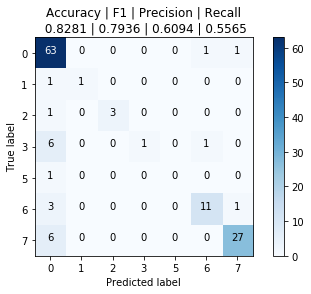

Building prefix dict from /home/katieyth/eReceipt/Head-first-Chinese-text-segmentation/data/dict.txt.big ...
Loading model from cache /tmp/jieba.u09c6586fc910ac41ac55d33d8714705d.cache


Loading model cost 1.544 seconds.
Prefix dict has been built succesfully.


Fold 5
Vocabulary Size: 7948
Train/Valid/Test split: 17752/2219/2219
(7948, 128)
(?, 12, 128)
h: (?, 10, 1, 128)
pooled: (?, 1, 1, 128)
h: (?, 9, 1, 128)
pooled: (?, 1, 1, 128)
h: (?, 8, 1, 128)
pooled: (?, 1, 1, 128)
self.h_pool: (?, 1, 1, 384)
INFO:tensorflow:Summary name embedding/W:0/grad/hist is illegal; using embedding/W_0/grad/hist instead.
INFO:tensorflow:Summary name embedding/W:0/grad/sparsity is illegal; using embedding/W_0/grad/sparsity instead.
INFO:tensorflow:Summary name conv-maxpool-3/W:0/grad/hist is illegal; using conv-maxpool-3/W_0/grad/hist instead.
INFO:tensorflow:Summary name conv-maxpool-3/W:0/grad/sparsity is illegal; using conv-maxpool-3/W_0/grad/sparsity instead.
INFO:tensorflow:Summary name conv-maxpool-3/b:0/grad/hist is illegal; using conv-maxpool-3/b_0/grad/hist instead.
INFO:tensorflow:Summary name conv-maxpool-3/b:0/grad/sparsity is illegal; using conv-maxpool-3/b_0/grad/sparsity instead.
INFO:tensorflow:Summary name conv-maxpool-4/W:0/grad/hist is illeg

[2018-07-18 18:42:39] EP(46/300) PT(10/25)---TR/VL-LOSS[0.9305/0.7338] ACC[0.7344/0.7812]|0.2 secs|l-rate:2.44140625e-10
[2018-07-18 18:42:40] EP(47/300) PT(11/25)---TR/VL-LOSS[1.2531/0.7862] ACC[0.6797/0.7500]|0.24 secs|l-rate:2.44140625e-10
[2018-07-18 18:42:40] ------------[REDUCE learning rate] to 1.220703125e-10
[2018-07-18 18:42:40] EP(48/300) PT(12/25)---TR/VL-LOSS[1.0464/0.7375] ACC[0.6719/0.7031]|0.2 secs|l-rate:1.220703125e-10
[2018-07-18 18:42:40] EP(49/300) PT(13/25)---TR/VL-LOSS[0.7724/0.6350] ACC[0.7812/0.7812]|0.24 secs|l-rate:1.220703125e-10
[2018-07-18 18:42:40] ------------[REDUCE learning rate] to 6.103515625e-11
[2018-07-18 18:42:40] EP(50/300) PT(14/25)---TR/VL-LOSS[0.8349/0.7955] ACC[0.7188/0.6953]|0.25 secs|l-rate:1e-10
[2018-07-18 18:42:41] EP(51/300) PT(15/25)---TR/VL-LOSS[0.9843/0.7469] ACC[0.6719/0.7109]|0.21 secs|l-rate:1e-10
[2018-07-18 18:42:41] ------------[REDUCE learning rate] to 5e-11
[2018-07-18 18:42:41] EP(52/300) PT(16/25)---TR/VL-LOSS[0.7950/0.679

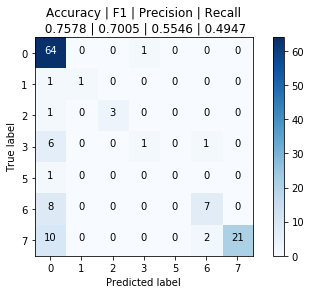

Building prefix dict from /home/katieyth/eReceipt/Head-first-Chinese-text-segmentation/data/dict.txt.big ...
Loading model from cache /tmp/jieba.u09c6586fc910ac41ac55d33d8714705d.cache


Loading model cost 1.583 seconds.
Prefix dict has been built succesfully.


Fold 6
Vocabulary Size: 7948
Train/Valid/Test split: 17752/2219/2219
(7948, 128)
(?, 12, 128)
h: (?, 10, 1, 128)
pooled: (?, 1, 1, 128)
h: (?, 9, 1, 128)
pooled: (?, 1, 1, 128)
h: (?, 8, 1, 128)
pooled: (?, 1, 1, 128)
self.h_pool: (?, 1, 1, 384)
INFO:tensorflow:Summary name embedding/W:0/grad/hist is illegal; using embedding/W_0/grad/hist instead.
INFO:tensorflow:Summary name embedding/W:0/grad/sparsity is illegal; using embedding/W_0/grad/sparsity instead.
INFO:tensorflow:Summary name conv-maxpool-3/W:0/grad/hist is illegal; using conv-maxpool-3/W_0/grad/hist instead.
INFO:tensorflow:Summary name conv-maxpool-3/W:0/grad/sparsity is illegal; using conv-maxpool-3/W_0/grad/sparsity instead.
INFO:tensorflow:Summary name conv-maxpool-3/b:0/grad/hist is illegal; using conv-maxpool-3/b_0/grad/hist instead.
INFO:tensorflow:Summary name conv-maxpool-3/b:0/grad/sparsity is illegal; using conv-maxpool-3/b_0/grad/sparsity instead.
INFO:tensorflow:Summary name conv-maxpool-4/W:0/grad/hist is illeg

[2018-07-18 18:43:12] EP(46/300) PT(2/25)---TR/VL-LOSS[0.8926/0.9591] ACC[0.6953/0.6406]|0.24 secs|l-rate:2.44140625e-10
[2018-07-18 18:43:12] EP(47/300) PT(3/25)---TR/VL-LOSS[1.0201/0.9984] ACC[0.7188/0.6875]|0.24 secs|l-rate:2.44140625e-10
[2018-07-18 18:43:12] ------------[REDUCE learning rate] to 1.220703125e-10
[2018-07-18 18:43:13] EP(48/300) PT(4/25)---TR/VL-LOSS[1.0960/0.6449] ACC[0.6875/0.7891]|0.38 secs|l-rate:1.220703125e-10
[2018-07-18 18:43:13] EP(49/300) PT(5/25)---TR/VL-LOSS[0.8591/0.8583] ACC[0.7734/0.7344]|0.23 secs|l-rate:1.220703125e-10
[2018-07-18 18:43:13] ------------[REDUCE learning rate] to 6.103515625e-11
[2018-07-18 18:43:13] EP(50/300) PT(6/25)---TR/VL-LOSS[0.7339/0.7662] ACC[0.7812/0.7578]|0.23 secs|l-rate:1e-10
[2018-07-18 18:43:13] EP(51/300) PT(7/25)---TR/VL-LOSS[0.9731/0.6964] ACC[0.6953/0.8125]|0.25 secs|l-rate:1e-10
[2018-07-18 18:43:13] ------------[REDUCE learning rate] to 5e-11
[2018-07-18 18:43:14] EP(52/300) PT(8/25)---TR/VL-LOSS[0.7800/0.6443] AC

[2018-07-18 18:43:27] EP(13/300) PT(7/25)---TR/VL-LOSS[0.8251/0.5810] ACC[0.7188/0.8438]|0.23 secs|l-rate:1.25e-07
[2018-07-18 18:43:27] ------------[REDUCE learning rate] to 6.25e-08
[2018-07-18 18:43:27] EP(14/300) PT(8/25)---TR/VL-LOSS[0.7684/0.5365] ACC[0.7656/0.8203]|0.37 secs|l-rate:6.25e-08
[2018-07-18 18:43:28] EP(15/300) PT(9/25)---TR/VL-LOSS[0.6130/0.5110] ACC[0.8359/0.8281]|0.24 secs|l-rate:6.25e-08
[2018-07-18 18:43:28] ------------[REDUCE learning rate] to 3.125e-08
[2018-07-18 18:43:28] EP(16/300) PT(10/25)---TR/VL-LOSS[0.5998/0.4975] ACC[0.8125/0.8672]|0.24 secs|l-rate:3.125e-08
[2018-07-18 18:43:28] EP(17/300) PT(11/25)---TR/VL-LOSS[0.6824/0.4350] ACC[0.7969/0.8594]|0.18 secs|l-rate:3.125e-08
[2018-07-18 18:43:28] ------------[REDUCE learning rate] to 1.5625e-08
[2018-07-18 18:43:28] EP(18/300) PT(12/25)---TR/VL-LOSS[0.6456/0.4834] ACC[0.8359/0.8047]|0.24 secs|l-rate:1.5625e-08
[2018-07-18 18:43:29] EP(19/300) PT(13/25)---TR/VL-LOSS[0.6906/0.6890] ACC[0.7891/0.7344]|0.2

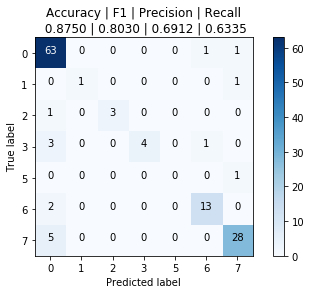

Building prefix dict from /home/katieyth/eReceipt/Head-first-Chinese-text-segmentation/data/dict.txt.big ...
Loading model from cache /tmp/jieba.u09c6586fc910ac41ac55d33d8714705d.cache


Loading model cost 1.487 seconds.
Prefix dict has been built succesfully.


Fold 7
Vocabulary Size: 7948
Train/Valid/Test split: 17752/2219/2219
(7948, 128)
(?, 12, 128)
h: (?, 10, 1, 128)
pooled: (?, 1, 1, 128)
h: (?, 9, 1, 128)
pooled: (?, 1, 1, 128)
h: (?, 8, 1, 128)
pooled: (?, 1, 1, 128)
self.h_pool: (?, 1, 1, 384)
INFO:tensorflow:Summary name embedding/W:0/grad/hist is illegal; using embedding/W_0/grad/hist instead.
INFO:tensorflow:Summary name embedding/W:0/grad/sparsity is illegal; using embedding/W_0/grad/sparsity instead.
INFO:tensorflow:Summary name conv-maxpool-3/W:0/grad/hist is illegal; using conv-maxpool-3/W_0/grad/hist instead.
INFO:tensorflow:Summary name conv-maxpool-3/W:0/grad/sparsity is illegal; using conv-maxpool-3/W_0/grad/sparsity instead.
INFO:tensorflow:Summary name conv-maxpool-3/b:0/grad/hist is illegal; using conv-maxpool-3/b_0/grad/hist instead.
INFO:tensorflow:Summary name conv-maxpool-3/b:0/grad/sparsity is illegal; using conv-maxpool-3/b_0/grad/sparsity instead.
INFO:tensorflow:Summary name conv-maxpool-4/W:0/grad/hist is illeg

[2018-07-18 18:44:01] EP(45/300) PT(6/25)---TR/VL-LOSS[0.7994/0.7963] ACC[0.7500/0.7656]|0.21 secs|l-rate:1e-10
[2018-07-18 18:44:01] EP(46/300) PT(7/25)---TR/VL-LOSS[0.7855/0.6232] ACC[0.7031/0.8125]|0.2 secs|l-rate:1e-10
[2018-07-18 18:44:01] ------------[REDUCE learning rate] to 5e-11
[2018-07-18 18:44:01] EP(47/300) PT(8/25)---TR/VL-LOSS[0.9974/0.8174] ACC[0.7188/0.6953]|0.22 secs|l-rate:1e-10
[2018-07-18 18:44:01] EP(48/300) PT(9/25)---TR/VL-LOSS[1.0407/0.6444] ACC[0.6875/0.7812]|0.23 secs|l-rate:1e-10
[2018-07-18 18:44:01] ------------[REDUCE learning rate] to 5e-11
[2018-07-18 18:44:02] EP(49/300) PT(10/25)---TR/VL-LOSS[0.7702/0.7350] ACC[0.7500/0.7734]|0.18 secs|l-rate:1e-10
[2018-07-18 18:44:02] EP(50/300) PT(11/25)---TR/VL-LOSS[0.7667/0.9843] ACC[0.7500/0.6875]|0.22 secs|l-rate:1e-10
[2018-07-18 18:44:02] ------------[REDUCE learning rate] to 5e-11
[2018-07-18 18:44:02] EP(51/300) PT(12/25)---TR/VL-LOSS[1.0276/0.7193] ACC[0.6719/0.7266]|0.24 secs|l-rate:1e-10
[2018-07-18 18:4

[2018-07-18 18:44:15] EP(104/300) PT(4/25)---TR/VL-LOSS[0.8235/0.4899] ACC[0.6953/0.8672]|0.17 secs|l-rate:1e-10
[2018-07-18 18:44:15] EP(105/300) PT(5/25)---TR/VL-LOSS[0.5980/0.5861] ACC[0.7734/0.8438]|0.25 secs|l-rate:1e-10
[2018-07-18 18:44:15] ------------[REDUCE learning rate] to 5e-11
[2018-07-18 18:44:15] EP(106/300) PT(6/25)---TR/VL-LOSS[0.6985/0.6709] ACC[0.8281/0.8125]|0.17 secs|l-rate:1e-10
[2018-07-18 18:44:15] EP(107/300) PT(7/25)---TR/VL-LOSS[0.8954/0.4343] ACC[0.7266/0.8281]|0.19 secs|l-rate:1e-10
[2018-07-18 18:44:15] ------------[REDUCE learning rate] to 5e-11
[2018-07-18 18:44:16] EP(108/300) PT(8/25)---TR/VL-LOSS[0.6624/0.5747] ACC[0.7812/0.8359]|0.26 secs|l-rate:1e-10
[2018-07-18 18:44:16] EP(109/300) PT(9/25)---TR/VL-LOSS[0.6542/0.5665] ACC[0.7656/0.7969]|0.24 secs|l-rate:1e-10
[2018-07-18 18:44:16] ------------[REDUCE learning rate] to 5e-11
[2018-07-18 18:44:16] EP(110/300) PT(10/25)---TR/VL-LOSS[0.6351/0.6110] ACC[0.8281/0.8438]|0.25 secs|l-rate:1e-10
[2018-07-1

[2018-07-18 18:44:29] EP(24/300) PT(0/25)---TR/VL-LOSS[0.5416/0.7422] ACC[0.8281/0.7578]|0.22 secs|l-rate:7.8125e-09
[2018-07-18 18:44:29] EP(25/300) PT(1/25)---TR/VL-LOSS[0.5603/0.3688] ACC[0.7812/0.8828]|0.17 secs|l-rate:7.8125e-09
[2018-07-18 18:44:29] ------------[REDUCE learning rate] to 3.90625e-09
[2018-07-18 18:44:29] EP(26/300) PT(2/25)---TR/VL-LOSS[0.5124/0.3819] ACC[0.8281/0.8750]|0.23 secs|l-rate:3.90625e-09
[2018-07-18 18:44:30] EP(27/300) PT(3/25)---TR/VL-LOSS[0.5877/0.4391] ACC[0.8047/0.8438]|0.24 secs|l-rate:3.90625e-09
[2018-07-18 18:44:30] ------------[REDUCE learning rate] to 1.953125e-09
[2018-07-18 18:44:30] EP(28/300) PT(4/25)---TR/VL-LOSS[0.5633/0.3709] ACC[0.8359/0.8828]|0.21 secs|l-rate:1.953125e-09
[2018-07-18 18:44:30] EP(29/300) PT(5/25)---TR/VL-LOSS[0.4156/0.4468] ACC[0.9062/0.8594]|0.22 secs|l-rate:1.953125e-09
[2018-07-18 18:44:30] ------------[REDUCE learning rate] to 9.765625e-10
[2018-07-18 18:44:30] EP(30/300) PT(6/25)---TR/VL-LOSS[0.5522/0.4115] ACC[

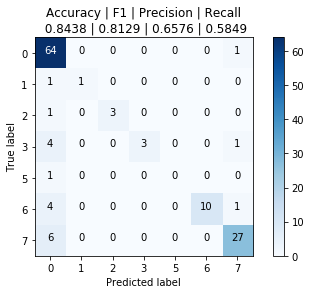

Building prefix dict from /home/katieyth/eReceipt/Head-first-Chinese-text-segmentation/data/dict.txt.big ...
Loading model from cache /tmp/jieba.u09c6586fc910ac41ac55d33d8714705d.cache


Loading model cost 1.685 seconds.
Prefix dict has been built succesfully.


Fold 8
Vocabulary Size: 7948
Train/Valid/Test split: 17752/2219/2219
(7948, 128)
(?, 12, 128)
h: (?, 10, 1, 128)
pooled: (?, 1, 1, 128)
h: (?, 9, 1, 128)
pooled: (?, 1, 1, 128)
h: (?, 8, 1, 128)
pooled: (?, 1, 1, 128)
self.h_pool: (?, 1, 1, 384)
INFO:tensorflow:Summary name embedding/W:0/grad/hist is illegal; using embedding/W_0/grad/hist instead.
INFO:tensorflow:Summary name embedding/W:0/grad/sparsity is illegal; using embedding/W_0/grad/sparsity instead.
INFO:tensorflow:Summary name conv-maxpool-3/W:0/grad/hist is illegal; using conv-maxpool-3/W_0/grad/hist instead.
INFO:tensorflow:Summary name conv-maxpool-3/W:0/grad/sparsity is illegal; using conv-maxpool-3/W_0/grad/sparsity instead.
INFO:tensorflow:Summary name conv-maxpool-3/b:0/grad/hist is illegal; using conv-maxpool-3/b_0/grad/hist instead.
INFO:tensorflow:Summary name conv-maxpool-3/b:0/grad/sparsity is illegal; using conv-maxpool-3/b_0/grad/sparsity instead.
INFO:tensorflow:Summary name conv-maxpool-4/W:0/grad/hist is illeg

[2018-07-18 18:44:56] EP(46/300) PT(6/25)---TR/VL-LOSS[0.7787/0.7535] ACC[0.7031/0.7812]|0.21 secs|l-rate:1e-10
[2018-07-18 18:44:56] EP(47/300) PT(7/25)---TR/VL-LOSS[1.0796/0.9812] ACC[0.6953/0.6953]|0.24 secs|l-rate:1e-10
[2018-07-18 18:44:56] ------------[REDUCE learning rate] to 5e-11
[2018-07-18 18:44:56] EP(48/300) PT(8/25)---TR/VL-LOSS[1.0675/0.7464] ACC[0.6641/0.8047]|0.24 secs|l-rate:1e-10
[2018-07-18 18:44:57] EP(49/300) PT(9/25)---TR/VL-LOSS[0.7972/0.7413] ACC[0.7656/0.7578]|0.23 secs|l-rate:1e-10
[2018-07-18 18:44:57] ------------[REDUCE learning rate] to 5e-11
[2018-07-18 18:44:57] EP(50/300) PT(10/25)---TR/VL-LOSS[0.7590/0.7097] ACC[0.7578/0.7891]|0.15 secs|l-rate:1e-10
[2018-07-18 18:44:57] EP(51/300) PT(11/25)---TR/VL-LOSS[0.9396/0.7890] ACC[0.7422/0.7578]|0.19 secs|l-rate:1e-10
[2018-07-18 18:44:57] ------------[REDUCE learning rate] to 5e-11
[2018-07-18 18:44:57] EP(52/300) PT(12/25)---TR/VL-LOSS[0.8064/0.6550] ACC[0.7266/0.7891]|0.4 secs|l-rate:1e-10
[2018-07-18 18:4

[2018-07-18 18:45:10] EP(104/300) PT(5/25)---TR/VL-LOSS[0.7974/0.5180] ACC[0.7344/0.8047]|0.23 secs|l-rate:1e-10
[2018-07-18 18:45:10] ------------[REDUCE learning rate] to 5e-11
[2018-07-18 18:45:10] EP(105/300) PT(6/25)---TR/VL-LOSS[0.5956/0.6393] ACC[0.7812/0.7734]|0.2 secs|l-rate:1e-10
[2018-07-18 18:45:10] EP(106/300) PT(7/25)---TR/VL-LOSS[0.6519/0.4716] ACC[0.8672/0.8594]|0.25 secs|l-rate:1e-10
[2018-07-18 18:45:10] ------------[REDUCE learning rate] to 5e-11
[2018-07-18 18:45:11] EP(107/300) PT(8/25)---TR/VL-LOSS[0.7136/0.5233] ACC[0.7500/0.8594]|0.25 secs|l-rate:1e-10
[2018-07-18 18:45:11] EP(108/300) PT(9/25)---TR/VL-LOSS[0.7297/0.4557] ACC[0.7891/0.8281]|0.2 secs|l-rate:1e-10
[2018-07-18 18:45:11] ------------[REDUCE learning rate] to 5e-11
[2018-07-18 18:45:11] EP(109/300) PT(10/25)---TR/VL-LOSS[0.6913/0.6068] ACC[0.7656/0.7812]|0.27 secs|l-rate:1e-10
[2018-07-18 18:45:11] EP(110/300) PT(11/25)---TR/VL-LOSS[0.6717/0.5174] ACC[0.7969/0.8281]|0.17 secs|l-rate:1e-10
[2018-07-18

[2018-07-18 18:45:24] EP(38/300) PT(13/25)---TR/VL-LOSS[0.4131/0.4387] ACC[0.8906/0.8359]|0.21 secs|l-rate:1e-10
[2018-07-18 18:45:24] ------------[REDUCE learning rate] to 5e-11
[2018-07-18 18:45:24] EP(39/300) PT(14/25)---TR/VL-LOSS[0.3557/0.3654] ACC[0.8984/0.8906]|0.16 secs|l-rate:1e-10
[2018-07-18 18:45:24] EP(40/300) PT(15/25)---TR/VL-LOSS[0.4373/0.5543] ACC[0.8672/0.8516]|0.24 secs|l-rate:1e-10
[2018-07-18 18:45:24] ------------[REDUCE learning rate] to 5e-11
[2018-07-18 18:45:24] EP(41/300) PT(16/25)---TR/VL-LOSS[0.5167/0.4643] ACC[0.8203/0.8828]|0.2 secs|l-rate:1e-10
[2018-07-18 18:45:24] EP(42/300) PT(17/25)---TR/VL-LOSS[0.4764/0.3657] ACC[0.8594/0.8828]|0.22 secs|l-rate:1e-10
[2018-07-18 18:45:24] ------------[REDUCE learning rate] to 5e-11
[2018-07-18 18:45:25] EP(43/300) PT(18/25)---TR/VL-LOSS[0.4121/0.3964] ACC[0.8750/0.8516]|0.19 secs|l-rate:1e-10
[2018-07-18 18:45:25] EP(44/300) PT(19/25)---TR/VL-LOSS[0.4805/0.5267] ACC[0.8203/0.8203]|0.2 secs|l-rate:1e-10
[2018-07-18 1

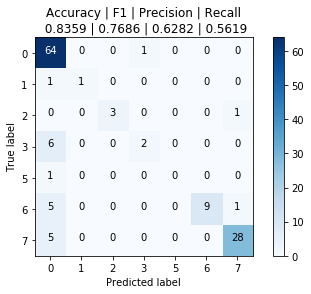

Building prefix dict from /home/katieyth/eReceipt/Head-first-Chinese-text-segmentation/data/dict.txt.big ...
Loading model from cache /tmp/jieba.u09c6586fc910ac41ac55d33d8714705d.cache


Loading model cost 1.707 seconds.
Prefix dict has been built succesfully.


Fold 9
Vocabulary Size: 7948
Train/Valid/Test split: 17752/2219/2219
(7948, 128)
(?, 12, 128)
h: (?, 10, 1, 128)
pooled: (?, 1, 1, 128)
h: (?, 9, 1, 128)
pooled: (?, 1, 1, 128)
h: (?, 8, 1, 128)
pooled: (?, 1, 1, 128)
self.h_pool: (?, 1, 1, 384)
INFO:tensorflow:Summary name embedding/W:0/grad/hist is illegal; using embedding/W_0/grad/hist instead.
INFO:tensorflow:Summary name embedding/W:0/grad/sparsity is illegal; using embedding/W_0/grad/sparsity instead.
INFO:tensorflow:Summary name conv-maxpool-3/W:0/grad/hist is illegal; using conv-maxpool-3/W_0/grad/hist instead.
INFO:tensorflow:Summary name conv-maxpool-3/W:0/grad/sparsity is illegal; using conv-maxpool-3/W_0/grad/sparsity instead.
INFO:tensorflow:Summary name conv-maxpool-3/b:0/grad/hist is illegal; using conv-maxpool-3/b_0/grad/hist instead.
INFO:tensorflow:Summary name conv-maxpool-3/b:0/grad/sparsity is illegal; using conv-maxpool-3/b_0/grad/sparsity instead.
INFO:tensorflow:Summary name conv-maxpool-4/W:0/grad/hist is illeg

[2018-07-18 18:45:48] EP(44/300) PT(11/25)---TR/VL-LOSS[0.8717/0.7665] ACC[0.6875/0.7422]|0.21 secs|l-rate:1e-10
[2018-07-18 18:45:48] ------------[REDUCE learning rate] to 5e-11
[2018-07-18 18:45:48] EP(45/300) PT(12/25)---TR/VL-LOSS[0.8719/0.8553] ACC[0.7188/0.7188]|0.23 secs|l-rate:1e-10
[2018-07-18 18:45:48] EP(46/300) PT(13/25)---TR/VL-LOSS[0.7745/0.9364] ACC[0.7266/0.6797]|0.23 secs|l-rate:1e-10
[2018-07-18 18:45:48] ------------[REDUCE learning rate] to 5e-11
[2018-07-18 18:45:48] EP(47/300) PT(14/25)---TR/VL-LOSS[1.1790/1.0132] ACC[0.6641/0.6875]|0.21 secs|l-rate:1e-10
[2018-07-18 18:45:48] EP(48/300) PT(15/25)---TR/VL-LOSS[1.1339/0.6352] ACC[0.6641/0.8203]|0.21 secs|l-rate:1e-10
[2018-07-18 18:45:49] EP(49/300) PT(0/25)---TR/VL-LOSS[0.9028/0.8165] ACC[0.6797/0.7344]|0.24 secs|l-rate:1e-10
[2018-07-18 18:45:49] EP(50/300) PT(1/25)---TR/VL-LOSS[0.7917/0.7010] ACC[0.7266/0.7812]|0.24 secs|l-rate:1e-10
[2018-07-18 18:45:49] ------------[REDUCE learning rate] to 5e-11
[2018-07-18 1

[2018-07-18 18:46:01] EP(102/300) PT(4/25)---TR/VL-LOSS[0.7451/0.7129] ACC[0.7578/0.7734]|0.25 secs|l-rate:1e-10
[2018-07-18 18:46:02] EP(103/300) PT(5/25)---TR/VL-LOSS[0.6462/0.6568] ACC[0.7656/0.7891]|0.24 secs|l-rate:1e-10
[2018-07-18 18:46:02] ------------[REDUCE learning rate] to 5e-11
[2018-07-18 18:46:02] EP(104/300) PT(6/25)---TR/VL-LOSS[0.7565/0.4902] ACC[0.7656/0.8281]|0.22 secs|l-rate:1e-10
[2018-07-18 18:46:02] EP(105/300) PT(7/25)---TR/VL-LOSS[0.6353/0.6385] ACC[0.7422/0.8047]|0.19 secs|l-rate:1e-10
[2018-07-18 18:46:02] ------------[REDUCE learning rate] to 5e-11
[2018-07-18 18:46:02] EP(106/300) PT(8/25)---TR/VL-LOSS[0.7556/0.4982] ACC[0.8281/0.8750]|0.22 secs|l-rate:1e-10
[2018-07-18 18:46:03] EP(107/300) PT(9/25)---TR/VL-LOSS[0.7910/0.5737] ACC[0.7188/0.8125]|0.23 secs|l-rate:1e-10
[2018-07-18 18:46:03] ------------[REDUCE learning rate] to 5e-11
[2018-07-18 18:46:03] EP(108/300) PT(10/25)---TR/VL-LOSS[0.6181/0.4458] ACC[0.7734/0.8828]|0.25 secs|l-rate:1e-10
[2018-07-1

[2018-07-18 18:46:15] EP(37/300) PT(9/25)---TR/VL-LOSS[0.4862/0.4404] ACC[0.8516/0.8750]|0.27 secs|l-rate:1e-10
[2018-07-18 18:46:15] ------------[REDUCE learning rate] to 5e-11
[2018-07-18 18:46:15] EP(38/300) PT(10/25)---TR/VL-LOSS[0.4157/0.4376] ACC[0.8750/0.8672]|0.26 secs|l-rate:1e-10
[2018-07-18 18:46:16] EP(39/300) PT(11/25)---TR/VL-LOSS[0.3972/0.5384] ACC[0.9141/0.8281]|0.25 secs|l-rate:1e-10
[2018-07-18 18:46:16] ------------[REDUCE learning rate] to 5e-11
[2018-07-18 18:46:16] EP(40/300) PT(12/25)---TR/VL-LOSS[0.4554/0.5880] ACC[0.8516/0.8438]|0.26 secs|l-rate:1e-10
[2018-07-18 18:46:16] EP(41/300) PT(13/25)---TR/VL-LOSS[0.4649/0.5654] ACC[0.9062/0.8047]|0.24 secs|l-rate:1e-10
[2018-07-18 18:46:16] ------------[REDUCE learning rate] to 5e-11
[2018-07-18 18:46:16] EP(42/300) PT(14/25)---TR/VL-LOSS[0.3854/0.5066] ACC[0.8828/0.8672]|0.26 secs|l-rate:1e-10
[2018-07-18 18:46:16] EP(43/300) PT(15/25)---TR/VL-LOSS[0.3742/0.4441] ACC[0.8750/0.8672]|0.19 secs|l-rate:1e-10
[2018-07-18 

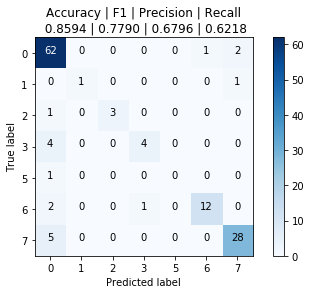

In [12]:
F1 = []
ACC= []
PRE= []
RCL= []
for idx_fold in range(10):
    #df = pd.read_csv('/mnt/nas_601/eReceipt/data/Product_Name_Classifier_Sample_CV/train_fold'+str(idx_fold)+'.csv')
    #df_test = pd.read_csv('/mnt/nas_601/eReceipt/data/Product_Name_Classifier_Sample_CV/test_fold'+str(idx_fold)+'.csv')
    df = pd.read_csv('/mnt/nas_601/eReceipt/data/product_name_classifier_test_label.csv')
    text_list = df.product_name
    x_text = cut_text(text_list)
    y = pd.get_dummies(df['label'])
    y = y.values

    # Build vocabulary
    max_document_length = max([len(x.split(" ")) for x in x_text])
    vocab_processor = learn.preprocessing.VocabularyProcessor(max_document_length)
    x = np.array(list(vocab_processor.fit_transform(x_text)))

    # Randomly shuffle data
    np.random.seed(10)
    shuffle_indices = np.random.permutation(np.arange(len(y)))
    x_shuffled = x[shuffle_indices]
    y_shuffled = y[shuffle_indices]
    pair_data = list(zip(x_shuffled, y_shuffled))

    data_train, data_test  = train_test_split(pair_data,  test_size= args.test2train_per)
    data_train, data_valid = train_test_split(data_train, test_size= args.val_per)



#     text_list = df_test.product_name
#     x_text = cut_text(text_list)
#     y = pd.get_dummies(df_test['label'])
#     y = y.values

#     # Build vocabulary
#     max_document_length = max([len(x.split(" ")) for x in x_text])
#     vocab_processor = learn.preprocessing.VocabularyProcessor(max_document_length)
#     x = np.array(list(vocab_processor.fit_transform(x_text)))

#     # Randomly shuffle data
#     np.random.seed(10)
#     shuffle_indices = np.random.permutation(np.arange(len(y)))
#     x_shuffled = x[shuffle_indices]
#     y_shuffled = y[shuffle_indices]
#     data_test = list(zip(x_shuffled, y_shuffled))
    print('Fold %s' %(idx_fold))
    print("Vocabulary Size: {:d}".format(len(vocab_processor.vocabulary_)))
    print("Train/Valid/Test split: {:d}/{:d}/{:d}".format(len(data_train), len(data_valid), len(data_test)))

    tf.reset_default_graph()
    sess=tf.Session()
    cnn = TextCNN(
        sequence_length=data_train[0][0].shape[0],
        num_classes=data_train[0][1].shape[0],
        vocab_size=len(vocab_processor.vocabulary_),
        embedding_size=args.embedding_dim,
        filter_sizes=list(map(int, args.filter_sizes.split(","))),
        num_filters=args.num_filters,
        l2_reg_lambda=args.l2_reg_lambda)

    # Define Training procedure
    global_step = tf.Variable(0, name="global_step", trainable=False)
    optimizer = tf.train.AdamOptimizer(1e-3)
    grads_and_vars = optimizer.compute_gradients(cnn.loss)
    train_op = optimizer.apply_gradients(grads_and_vars, global_step=global_step)

    # Keep track of gradient values and sparsity (optional)
    grad_summaries = []
    for g, v in grads_and_vars:
        if g is not None:
            grad_hist_summary = tf.summary.histogram("{}/grad/hist".format(v.name), g)
            sparsity_summary = tf.summary.scalar("{}/grad/sparsity".format(v.name), tf.nn.zero_fraction(g))
            grad_summaries.append(grad_hist_summary)
            grad_summaries.append(sparsity_summary)
    grad_summaries_merged = tf.summary.merge(grad_summaries)

    # Output directory for models and summaries
    timestamp = str(int(time.time()))
    out_dir = os.path.abspath(os.path.join(os.path.curdir, "runs", timestamp))
    print("Writing to {}\n".format(out_dir))

    # Summaries for loss and accuracy
    loss_summary = tf.summary.scalar("loss", cnn.loss)
    acc_summary = tf.summary.scalar("accuracy", cnn.accuracy)

    # Train Summaries
    train_summary_op = tf.summary.merge([loss_summary, acc_summary, grad_summaries_merged])
    train_summary_dir = os.path.join(out_dir, "summaries", "train")
    train_summary_writer = tf.summary.FileWriter(train_summary_dir, sess.graph)

    # Dev summaries
    dev_summary_op = tf.summary.merge([loss_summary, acc_summary])
    dev_summary_dir = os.path.join(out_dir, "summaries", "dev")
    dev_summary_writer = tf.summary.FileWriter(dev_summary_dir, sess.graph)

    # Checkpoint directory. Tensorflow assumes this directory already exists so we need to create it
    checkpoint_dir = os.path.abspath(os.path.join(out_dir, "checkpoints"))
    checkpoint_prefix = os.path.join(checkpoint_dir, "model")
    if not os.path.exists(checkpoint_dir):
        os.makedirs(checkpoint_dir)
    saver = tf.train.Saver(tf.global_variables(), max_to_keep=3)

    # Write vocabulary
    vocab_processor.save(os.path.join(out_dir, "vocab"))

    # Initialize all variables
    sess.run(tf.global_variables_initializer())





    datagen = DataGenerator()
    train_gen = datagen.gen_train_data(data_train, bz=args.bz)
    valid_gen = datagen.get_test_data (data_valid, bz=args.bz)
    test_gen  = datagen.get_test_data (data_test,  bz=args.bz)

    train_iter = int(np.ceil(len(data_train)/(args.bz))) 
    valid_iter = int(np.ceil(len(data_valid)/(args.bz))) 
    test_iter  = int(np.ceil(len(data_test )/(args.bz)))
    if args.test_mode == True:
            train_iter, valid_iter, test_iter = 2, 2, 2

    lr_patience_counter =0
    step_patience_counter =0
    l_rate = args.lr
    current_best_val_loss = None
    epoch_counter = 1

    params = {}
    params['train_loss']=[]
    params['valid_loss']=[]
    params['train_score']=[]
    params['valid_score']=[]

    while(step_patience_counter < args.earlystop_patience): #+1 ?

        st = time.time()
        train_batch_losses = []
        train_batch_accs = []
        valid_batch_losses = []
        valid_batch_accs = []
        for batch_i in range(train_iter):
            print('\r[TRAINING]-----train-mini-Batch ({}/{})'.format(batch_i+1, train_iter), end='\r')                
            x_train_batch, y_train_batch = next(train_gen) 

            TR_loss, TR_acc = train_step(x_train_batch, y_train_batch)
            train_batch_losses.append(TR_loss)
            train_batch_accs.append(TR_acc)

        # Do the validation on a small set of validation images
        for batch_i in range(valid_iter):
            print('\r[Validating]-----valid-mini-Batch ({}/{})'.format(batch_i+1, valid_iter), end='\r')
            x_valid_batch, y_valid_batch = next(valid_gen)

            VL_loss, VL_acc, pred = dev_step(x_valid_batch, y_valid_batch, writer=dev_summary_writer)
            valid_batch_losses.append(VL_loss)
            valid_batch_accs.append(VL_acc)

        train_epoch_loss = np.mean(train_batch_losses)
        valid_epoch_loss = np.mean(valid_batch_losses)
        params['train_loss'].extend([train_epoch_loss])
        params['valid_loss'].extend([valid_epoch_loss])
        plt_learning_curve(params['train_loss'],params['valid_loss'])

        train_epoch_acc = np.mean(train_batch_accs)
        valid_epoch_acc = np.mean(valid_batch_accs)


        epoch_counter+=1

        get_epoch_report()

        #get_remaining_time()
        st = time.time()

        step_patience_counter,l_rate,lr_patience_counter = get_lr_step_patience()

        if epoch_counter >= args.epoch:
            break
            log.log('Training ended. Running time: {}'.format(datetime.now()-start_time))




    datagen = DataGenerator()
    train_gen = datagen.gen_train_data(data_train, bz=args.bz)
    valid_gen = datagen.get_test_data (data_valid, bz=args.bz)
    test_gen  = datagen.get_test_data (data_test,  bz=args.bz)

    train_iter = int(np.ceil(len(data_train)/(args.bz))) 
    valid_iter = int(np.ceil(len(data_valid)/(args.bz))) 
    test_iter  = int(np.ceil(len(data_test )/(args.bz)))
    if args.test_mode == True:
            train_iter, valid_iter, test_iter = 2, 2, 2

    lr_patience_counter =0
    step_patience_counter =0
    l_rate = args.lr
    current_best_val_loss = None
    epoch_counter = 1

    params = {}
    params['train_loss']=[]
    params['valid_loss']=[]
    params['train_score']=[]
    params['valid_score']=[]

    while(step_patience_counter < args.earlystop_patience): #+1 ?

        st = time.time()
        train_batch_losses = []
        train_batch_accs = []
        valid_batch_losses = []
        valid_batch_accs = []
        for batch_i in range(train_iter):
            print('\r[TRAINING]-----train-mini-Batch ({}/{})'.format(batch_i+1, train_iter), end='\r')                
            x_train_batch, y_train_batch = next(train_gen) 

            TR_loss, TR_acc = train_step(x_train_batch, y_train_batch)
            train_batch_losses.append(TR_loss)
            train_batch_accs.append(TR_acc)

        # Do the validation on a small set of validation images
        for batch_i in range(valid_iter):
            print('\r[Validating]-----valid-mini-Batch ({}/{})'.format(batch_i+1, valid_iter), end='\r')
            x_valid_batch, y_valid_batch = next(valid_gen)

            VL_loss, VL_acc, pred = dev_step(x_valid_batch, y_valid_batch, writer=dev_summary_writer)
            valid_batch_losses.append(VL_loss)
            valid_batch_accs.append(VL_acc)

        train_epoch_loss = np.mean(train_batch_losses)
        valid_epoch_loss = np.mean(valid_batch_losses)
        params['train_loss'].extend([train_epoch_loss])
        params['valid_loss'].extend([valid_epoch_loss])
        plt_learning_curve(params['train_loss'],params['valid_loss'])

        train_epoch_acc = np.mean(train_batch_accs)
        valid_epoch_acc = np.mean(valid_batch_accs)


        epoch_counter+=1

        get_epoch_report()

        #get_remaining_time()
        st = time.time()

        step_patience_counter,l_rate,lr_patience_counter = get_lr_step_patience()

        if epoch_counter >= args.epoch:
            break
            log.log('Training ended. Running time: {}'.format(datetime.now()-start_time))
            
        test_batch_losses = []
        test_batch_accs = []
        all_y_true=[]
        all_prediction = []
    for batch_i in range(test_iter):
        print('\r[TESTING]-----test-mini-Batch ({}/{})'.format(batch_i+1, test_iter), end='\r')                
        x_test_batch, y_test_batch = next(test_gen) 

        TE_loss, TE_acc, pred = dev_step(x_test_batch, y_test_batch)
        test_batch_losses.append(TE_loss)
        test_batch_accs.append(TE_acc)

        df_y_batch = pd.DataFrame(y_test_batch)
        y_true = df_y_batch.idxmax(axis=1)
        all_y_true = np.concatenate([all_y_true, y_true])
        all_prediction = np.concatenate([all_prediction, pred])

    # Do the validation on a small set of validation images      
            
            
    



    correct_predictions = float(sum(all_prediction == all_y_true))
    overall_acc = correct_predictions/float(len(all_y_true))
    print("Total number of test examples: {}".format(len(all_y_true)))
    print("Accuracy: {:g}".format(overall_acc))


    import itertools
    def plot_confusion_matrix(cm, classes,
                              normalize=False,
                              title='Confusion matrix',
                              cmap=plt.cm.Blues):
        """
        This function prints and plots the confusion matrix.
        Normalization can be applied by setting `normalize=True`.
        """
        if normalize:
            cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
            print("Normalized confusion matrix")
        else:
            print('Confusion matrix, without normalization')

        print(cm)

        plt.imshow(cm, interpolation='nearest', cmap=cmap)
        plt.title(title)
        plt.colorbar()
        tick_marks = np.arange(len(classes))
        plt.xticks(tick_marks, classes, rotation=0)
        plt.yticks(tick_marks, classes)

        fmt = '.2f' if normalize else 'd'
        thresh = cm.max() / 2.
        for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
            plt.text(j, i, format(cm[i, j], fmt),
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black")

        plt.tight_layout()
        plt.ylabel('True label')
        plt.xlabel('Predicted label')
    
    
    class_names = (list(set(all_y_true)))
    class_names = [str(int(i)) for i in class_names]
    overall_F1 = f1_score(all_y_true, all_prediction, average='macro')
    overall_rcal = recall_score(all_y_true, all_prediction, average='macro')
    overall_prec = precision_score(all_y_true, all_prediction, average='macro')
    overall_acc = accuracy_score(all_y_true, all_prediction)
    
    
    F1.append(overall_F1) 
    RCL.append(overall_rcal)
    PRE.append(overall_prec)
    ACC.append(overall_acc)
    
    cnf_matrix = confusion_matrix(all_y_true, all_prediction)
    plot_confusion_matrix(cnf_matrix, classes=class_names,
                  title='Accuracy | F1 | Precision | Recall\n %.4f | %.4f | %.4f | %.4f' %(overall_acc, overall_prec, overall_F1, overall_rcal))
    plt.savefig(os.path.join(img_dir+'/CNV_MTX_'+running_date+'_'+running_time+'_fold_'+ str(idx_fold)+'.png'))
    plt.show()   

        
        
#     plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
#     plt.title(title)
#     plt.colorbar()
#     tick_marks = np.arange(len(class_names))
#     plt.xticks(tick_marks, classes, rotation=0)
#     plt.yticks(tick_marks, classes)

#     fmt = '.2f' if normalize else 'd'
#     thresh = cm.max() / 2.
#     for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
#         plt.text(j, i, format(cm[i, j], fmt),
#                  horizontalalignment="center",
#                  color="white" if cm[i, j] > thresh else "black")
#     plt.tight_layout()
#     plt.ylabel('True label')
#     plt.xlabel('Predicted label')
#     plt.savefig(os.path.join(img_dir+'/CNV_MTX_'+running_date+'_'+running_time+'_fold_'+ str(idx_fold)+'.png'))
#     plt.show()

In [13]:
for batch_i in range(train_iter):
    print('\r[TRAINING]-----train-mini-Batch ({}/{})'.format(batch_i+1, train_iter), end='\r')                
    x_train_batch, y_train_batch = next(train_gen) 

    TR_loss, TR_acc = train_step(x_train_batch, y_train_batch)
    train_batch_losses.append(TR_loss)
    train_batch_accs.append(TR_acc)
